In [740]:
import pandas as pd
import numpy as np
import plotly.express as px
# Load packages
import logging
import pickle
import os
import sklearn
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


In [741]:
PATH = '../data/processed/encoded_df.pkl'


In [742]:
encoded_df = pd.read_pickle(PATH)


In [743]:
encoded_df

DevType                                           \
      Academic researcher Blockchain Cloud infrastructure engineer   
0                       0          0                             0   
1                       0          0                             0   
2                       0          0                             0   
3                       0          0                             0   
8                       0          0                             0   
...                   ...        ...                           ...   
64329                   0          0                             0   
64331                   0          0                             0   
64333                   0          0                             0   
64335                   0          0                             0   
64337                   0          0                             0   

                                                                              \
      Data or business analyst Data scientist or machine learning specialist   
0                            0                                             0   
1                            0                                             0   
2                            0                                             0   
3                            0                                             0   
8                            0                                             0   
...                        ...                                           ...   
64329                        0                                             0   
64331                        0                                             0   
64333                        0                                             0   
64335                        0                                             0   
64337                        0                                             0   

                                                                      \
      Database administrator DevOps specialist Developer, QA or test   
0                          0                 0                     0   
1                          0                 0                     0   
2                          0                 0                     0   
3                          0                 0                     0   
8                          0                 0                     0   
...                      ...               ...                   ...   
64329                      0                 0                     0   
64331                      0                 0                     0   
64333                      0                 0                     0   
64335                      0                 0                     0   
64337                      0                 0                     0   

                                                                         ...  \
      Developer, back-end Developer, desktop or enterprise applications  ...   
0                       1                                             0  ...   
1                       0                                             0  ...   
2                       0                                             0  ...   
3                       1                                             0  ...   
8                       0                                             1  ...   
...                   ...                                           ...  ...   
64329                   0                                             0  ...   
64331                   0                                             0  ...   
64333                   0                                             0  ...   
64335                   1                                             0  ...   
64337                   0                                             0  ...   

      DeveloperTools                                                     \
             

In [744]:
std_skills = StandardScaler().fit_transform(encoded_df.copy().drop('DevType', axis=1))


In [745]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=encoded_df.copy().drop('DevType', axis=1).columns)

In [746]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

In [747]:
range_n_cluster = list(range(10,30))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

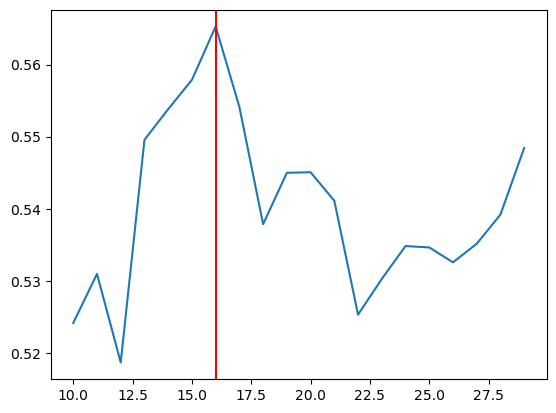

In [748]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='red')

In [749]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=best_cluster_model.labels_)
fig.update_traces(textposition='top center')
fig.update_layout(height=900, width=900, title_text='Cluster')
fig.show()

sklearn.metrics.get_scorer_names() 

In [750]:
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(best_cluster_model.labels_).apply(list)

In [751]:
skills_clusters.shape

(16,)

In [752]:
skills_df = encoded_df.copy().drop('DevType', axis=1).droplevel(0, axis=1)

In [753]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_df[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)
combined_features_df = pd.concat([fe_clustered_skills, 
                                  skills_df], 
                                 axis=1)


In [754]:
new_skills_group = []
for cluster in skills_clusters:
    new_skills_group.append(skills_df[cluster].sum(axis=1))

In [755]:
new_skill_df = pd.concat(new_skills_group, axis=1)
new_skill_df.columns = [f"skill_cluster_{i}" for i in range(0, len(skills_clusters))]

## Clustering Back-end

In [756]:
grouping_skills = ['Language', 'Platform', 'Webframe','MiscTech', 'Database']

jobs_to_cluster = ['Developer, back-end', 'Developer, full-stack']

back_end_df = encoded_df[encoded_df[('DevType', 'Developer, back-end')]==1][grouping_skills]
std__backend_skills = StandardScaler().fit_transform(back_end_df.copy())
tsne_back_end_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std__backend_skills.T)

tsne_back_end_projection = pd.DataFrame(tsne_back_end_projection, index=back_end_df.copy().columns)
fig = px.scatter(x=tsne_back_end_projection[0], y=tsne_back_end_projection[1], text=tsne_back_end_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

In [757]:
range_n_cluster = list(range(10,50))
silhoutte_score_db = []
silhoutte_score_agg= []

best_cluster_db = None 
best_cluster_ag = None
eps = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_cluster:
    agg_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    agg_labels = agg_model.fit_predict(tsne_back_end_projection)
   
    silhouette_avg = silhouette_score(tsne_back_end_projection, agg_labels)
    silhoutte_score_agg += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score_agg):
        best_cluster_agg = agg_model

for e in eps:
    db_model  = DBSCAN(eps=e, min_samples=2)
    db_labels = db_model.fit_predict(tsne_back_end_projection)
    
    silhouette_avg = silhouette_score(tsne_back_end_projection, db_labels)
    silhoutte_score_db += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score_db):
        best_cluster_db = db_model

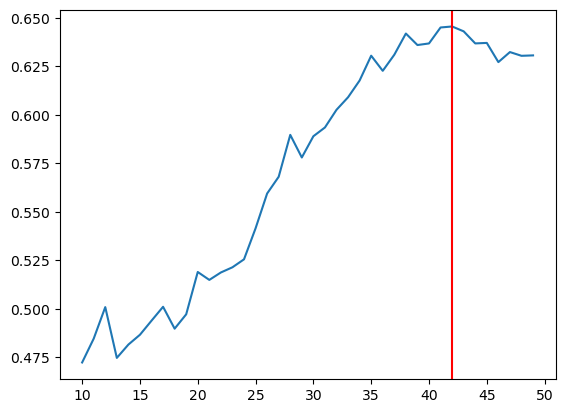

In [758]:
plt.plot(range_n_cluster, silhoutte_score_agg)
plt.axvline(best_cluster_agg.n_clusters, color='red')

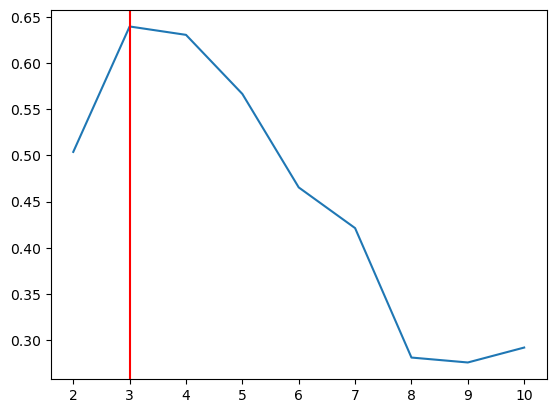

In [759]:
plt.plot(eps, silhoutte_score_db)
plt.axvline(best_cluster_db.get_params()['eps'], color='red')


In [760]:
fig = px.scatter(x=tsne_back_end_projection[0], y=tsne_back_end_projection[1], 
                 text=tsne_back_end_projection.droplevel(0).index, color=best_cluster_db.labels_)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

In [761]:
backedn_skills_clusters = tsne_back_end_projection.index.droplevel(0).to_series().groupby(best_cluster_db.labels_).apply(list)
backedn_skills_clusters.reset_index(drop=True, inplace=True)



In [762]:
major_clusters = []
for cluster in backedn_skills_clusters:
        major_clusters.append(cluster) if len(cluster) >= 3 else None

print(len(major_clusters))

33


In [763]:
for cluster in major_clusters:
    print(cluster)
    print('---------------------')

['jQuery', 'MongoDB', 'Neo4J']
---------------------
['APL', 'R', 'Tidyverse', 'Couch DB']
---------------------
['Ada', 'Flow', 'OCaml']
---------------------
['Apex', 'OpenShift', 'Oracle Cloud Infrastructure (OCI)', 'Oracle']
---------------------
['Assembly', 'C', 'C++', 'GTK', 'MFC', 'OpenGL', 'Qt']
---------------------
['Bash/Shell (all shells)', 'Python', 'Django', 'FastAPI', 'Flask', 'SQLite']
---------------------
['C#', 'F#', 'PowerShell', 'Microsoft Azure', 'ASP.NET CORE', 'Blazor', '.NET (5+) ', 'Cosmos DB', 'Microsoft SQL Server', 'RavenDB']
---------------------
['Clojure', 'GDScript', 'Lisp', 'Datomic']
---------------------
['Cobol', 'SAS', 'IBM Cloud Or Watson', 'IBM DB2']
---------------------
['Crystal', 'Ruby', 'Heroku', 'Render', 'Ruby on Rails']
---------------------
['Elixir', 'Erlang', 'Fly.io', 'Phoenix']
---------------------
['Fortran', 'Julia', 'MATLAB']
---------------------
['Go', 'Google Cloud', 'BigQuery', 'Cockroachdb', 'TiDB']
---------------------
['

In [764]:
keys =['drop', 'drop0', 'drop00', 'Oracle', 'C/C++',  'Python', '.NET', 'drop1','drop2', 'Ruby', 'Elixir',
       'drop2', 'drop22', 'Java', 'drop3', 'drop4', 'drop5', 'Rust', 'drop33', 'Swift', 'PHP', 
       'Scala/Big data', 'drop6', 'React[NAtive]', 'drop7', 'drop8', 'drop91', 'drop71', 'drop81', 'drop9', 'AI', 'drop10'
       ]

In [765]:
backend_groups = dict(zip(keys, major_clusters))
backend_groups

{'drop': ['jQuery', 'MongoDB', 'Neo4J'],
 'drop0': ['APL', 'R', 'Tidyverse', 'Couch DB'],
 'drop00': ['Ada', 'Flow', 'OCaml'],
 'Oracle': ['Apex',
  'OpenShift',
  'Oracle Cloud Infrastructure (OCI)',
  'Oracle'],
 'C/C++': ['Assembly', 'C', 'C++', 'GTK', 'MFC', 'OpenGL', 'Qt'],
 'Python': ['Bash/Shell (all shells)',
  'Python',
  'Django',
  'FastAPI',
  'Flask',
  'SQLite'],
 '.NET': ['C#',
  'F#',
  'PowerShell',
  'Microsoft Azure',
  'ASP.NET CORE',
  'Blazor',
  '.NET (5+) ',
  'Cosmos DB',
  'Microsoft SQL Server',
  'RavenDB'],
 'drop1': ['Clojure', 'GDScript', 'Lisp', 'Datomic'],
 'drop2': ['Fortran', 'Julia', 'MATLAB'],
 'Ruby': ['Crystal', 'Ruby', 'Heroku', 'Render', 'Ruby on Rails'],
 'Elixir': ['Elixir', 'Erlang', 'Fly.io', 'Phoenix'],
 'drop22': ['Go', 'Google Cloud', 'BigQuery', 'Cockroachdb', 'TiDB'],
 'Java': ['Groovy',
  'Java',
  'Spring Boot',
  'JAX',
  'Quarkus',
  'Spring Framework',
  'H2'],
 'drop3': ['HTML/CSS', 'JavaScript', 'SQL'],
 'drop4': ['Haskell', 'Pro

In [766]:
backend_groups = {key: value for key, value in backend_groups.items() if 'drop' not in key}
print(len(backend_groups))


13


In [767]:
backend_groups

{'Oracle': ['Apex',
  'OpenShift',
  'Oracle Cloud Infrastructure (OCI)',
  'Oracle'],
 'C/C++': ['Assembly', 'C', 'C++', 'GTK', 'MFC', 'OpenGL', 'Qt'],
 'Python': ['Bash/Shell (all shells)',
  'Python',
  'Django',
  'FastAPI',
  'Flask',
  'SQLite'],
 '.NET': ['C#',
  'F#',
  'PowerShell',
  'Microsoft Azure',
  'ASP.NET CORE',
  'Blazor',
  '.NET (5+) ',
  'Cosmos DB',
  'Microsoft SQL Server',
  'RavenDB'],
 'Ruby': ['Crystal', 'Ruby', 'Heroku', 'Render', 'Ruby on Rails'],
 'Elixir': ['Elixir', 'Erlang', 'Fly.io', 'Phoenix'],
 'Java': ['Groovy',
  'Java',
  'Spring Boot',
  'JAX',
  'Quarkus',
  'Spring Framework',
  'H2'],
 'Rust': ['Lua', 'Rust', 'Solid.js', 'Svelte', 'Tauri'],
 'Swift': ['Objective-C', 'Swift', 'SwiftUI'],
 'PHP': ['PHP',
  'CodeIgniter',
  'Laravel',
  'Symfony',
  'WordPress',
  'MariaDB',
  'MySQL'],
 'Scala/Big data': ['Scala', 'Play Framework', 'Apache Spark', 'Hadoop'],
 'React[NAtive]': ['TypeScript',
  'Express',
  'Fastify',
  'NestJS',
  'Node.js',
  '

In [768]:
# Add new columns to the DevType column
for key in backend_groups.keys():
    encoded_df[('DevType', f"{key}-back-end")] = 0
    encoded_df[('DevType', f"{key}-full-stack")] = 0
encoded_df

DevType                                           \
      Academic researcher Blockchain Cloud infrastructure engineer   
0                       0          0                             0   
1                       0          0                             0   
2                       0          0                             0   
3                       0          0                             0   
8                       0          0                             0   
...                   ...        ...                           ...   
64329                   0          0                             0   
64331                   0          0                             0   
64333                   0          0                             0   
64335                   0          0                             0   
64337                   0          0                             0   

                                                                              \
      Data or business analyst Data scientist or machine learning specialist   
0                            0                                             0   
1                            0                                             0   
2                            0                                             0   
3                            0                                             0   
8                            0                                             0   
...                        ...                                           ...   
64329                        0                                             0   
64331                        0                                             0   
64333                        0                                             0   
64335                        0                                             0   
64337                        0                                             0   

                                                                      \
      Database administrator DevOps specialist Developer, QA or test   
0                          0                 0                     0   
1                          0                 0                     0   
2                          0                 0                     0   
3                          0                 0                     0   
8                          0                 0                     0   
...                      ...               ...                   ...   
64329                      0                 0                     0   
64331                      0                 0                     0   
64333                      0                 0                     0   
64335                      0                 0                     0   
64337                      0                 0                     0   

                                                                         ...  \
      Developer, back-end Developer, desktop or enterprise applications  ...   
0                       1                                             0  ...   
1                       0                                             0  ...   
2                       0                                             0  ...   
3                       1                                             0  ...   
8                       0                                             1  ...   
...                   ...                                           ...  ...   
64329                   0                                             0  ...   
64331                   0                                             0  ...   
64333                   0                                             0  ...   
64335                   1                                             0  ...   
64337                   0                                             0  ...   

                                                                   \
      Swift-back-en

In [769]:
def update_backend_groups(row, job_class):
    skills_score = []
    job = None
    for subgroup, skills in backend_groups.items():
        
        sum = row.copy().sort_index().drop('DevType').droplevel(0)[skills].sum() / len(skills) * 100
        skills_score.append(sum)
        if sum >= max(skills_score) and sum > 0.5:
            job = subgroup
    if job:
        row[('DevType', f"{job}-{job_class}")] = 1
        row[('DevType', f"Developer, {job_class}")] = 0
    return row


In [770]:
mask = encoded_df[('DevType', 'Developer, back-end')] == 1

encoded_df.loc[mask] = encoded_df.loc[mask].apply(update_backend_groups, job_class='back-end', axis=1)


In [771]:
mask = encoded_df[('DevType', 'Developer, full-stack')] == 1

encoded_df.loc[mask] = encoded_df.loc[mask].apply(update_backend_groups, job_class='full-stack', axis=1)


In [772]:
encoded_df['DevType'].sum().sort_values(ascending=False)

.NET-full-stack                                  4149
React[NAtive]-full-stack                         4099
Developer, front-end                             4084
Developer, desktop or enterprise applications    3192
PHP-full-stack                                   2849
Python-back-end                                  2556
Python-full-stack                                2235
Developer, mobile                                2145
Java-back-end                                    2006
.NET-back-end                                    1821
Developer, embedded applications or devices      1558
Java-full-stack                                  1490
Data scientist or machine learning specialist    1221
PHP-back-end                                     1220
Academic researcher                              1038
Research & Development role                      1016
Engineer, data                                    945
React[NAtive]-back-end                            918
DevOps specialist           

## Merger Academic researcher with scientist

In [773]:
encoded_df[('DevType', 'Scientest/Researcher')] = encoded_df[('DevType', 'Academic researcher')] | encoded_df[('DevType','Scientist')]
encoded_df.drop([('DevType', 'Academic researcher'), ('DevType','Scientist')], axis=1, inplace=True)


In [774]:

new_skill_df.columns = pd.MultiIndex.from_product([['skills_clusters'],  new_skill_df.columns])


In [775]:
df = pd.concat([encoded_df, new_skill_df], axis=1).reset_index(drop=True)
df.to_pickle('../data/processed/data_engineered_df.pkl')

In [776]:
import json
skill_group_dict = dict(zip(new_skill_df['skills_clusters'].columns, skills_clusters))


# Define the file path
json_file_path = '../data/processed/skill_group_dict.json'

# Convert the dictionary to JSON format
json_data = json.dumps(skill_group_dict)

# Write the JSON data to the file
with open(json_file_path, 'w') as json_file:
    json_file.write(json_data)
